In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from rake_nltk import Rake
from nltk.corpus import stopwords

In [2]:
dataset = pd.read_csv('IMDb movies.csv')
dataset.head()

/Users/macbookpro/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


## Cleaning

In [3]:
print(dataset.shape)
dataset.isnull().sum()

(85855, 22)


imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                     64
language                   833
director                    87
writer                    1572
production_company        4455
actors                      69
description               2115
avg_vote                     0
votes                        0
budget                   62145
usa_gross_income         70529
worlwide_gross_income    54839
metascore                72550
reviews_from_users        7597
reviews_from_critics     11797
dtype: int64

In [4]:
dataset.drop(['budget','usa_gross_income','metascore', 'worlwide_gross_income'], axis=1, inplace=True)
dataset.dropna(subset=['country', 'language'], how='all', inplace=True)
dataset.dropna(subset=['director', 'actors', 'reviews_from_users', 'reviews_from_critics'], how='any', inplace=True)

In [5]:
# def fill_country_lang(row):
#     if row.isnull().country:
#         row['language'] = dataset[dataset.country == row.country].language.mode()[0]
#     elif row.isnull().language:
#         row['country'] = dataset[dataset.language == row.language].country.mode()[0]
        
# dataset[:5].apply(fill_country_lang, axis=1)

In [6]:
dataset.country.fillna('None', inplace=True)
dataset.language.fillna('None', inplace=True)
dataset.production_company.fillna('None', inplace=True)
dataset.writer.fillna('None', inplace=True)
dataset.description.fillna('None', inplace=True)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69897 entries, 0 to 85851
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_title_id         69897 non-null  object 
 1   title                 69897 non-null  object 
 2   original_title        69897 non-null  object 
 3   year                  69897 non-null  object 
 4   date_published        69897 non-null  object 
 5   genre                 69897 non-null  object 
 6   duration              69897 non-null  int64  
 7   country               69897 non-null  object 
 8   language              69897 non-null  object 
 9   director              69897 non-null  object 
 10  writer                69897 non-null  object 
 11  production_company    69897 non-null  object 
 12  actors                69897 non-null  object 
 13  description           69897 non-null  object 
 14  avg_vote              69897 non-null  float64
 15  votes              

In [8]:
dataset.loc[dataset.year == 'TV Movie 2019', 'year'] = 2019
dataset['year'] = dataset.year.astype('int')

In [9]:
dataset[['reviews_from_critics', 'reviews_from_users']] = MinMaxScaler().fit_transform(dataset[['reviews_from_critics', 'reviews_from_users']])


In [10]:
clean_dataset = dataset
clean_dataset.shape

(69897, 18)

## EDA

<AxesSubplot:xlabel='count', ylabel='genre'>

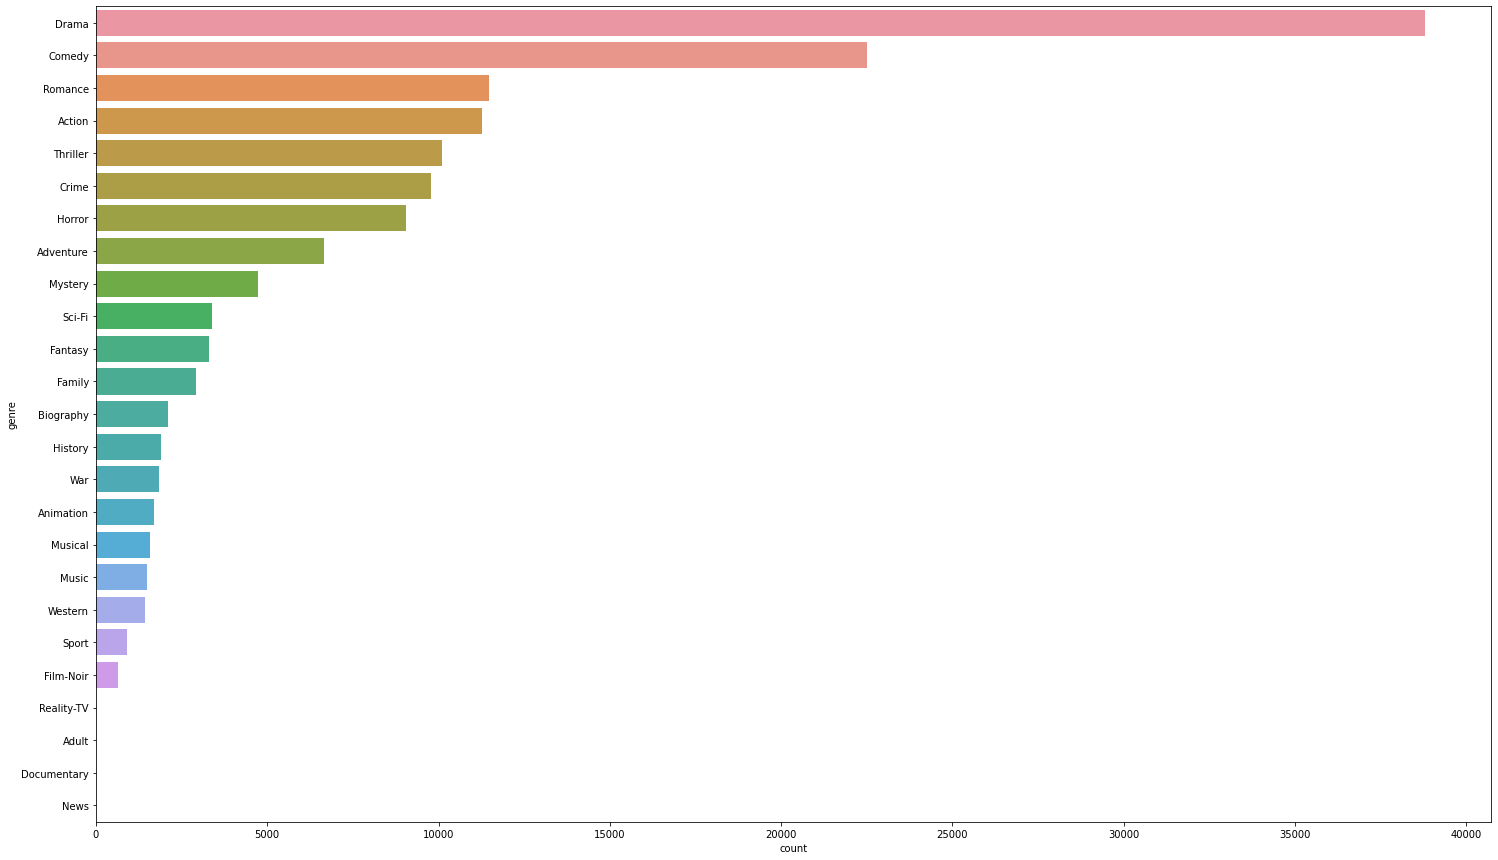

In [11]:
dataset_genre = pd.DataFrame(clean_dataset['genre'].str.split(', '), columns=['genre'])
dataset_genre = dataset_genre.explode('genre')
plt.figure(figsize=(25,15))
sns.countplot(y=dataset_genre['genre'], orient='h', order=dataset_genre['genre'].value_counts().index)

<AxesSubplot:xlabel='count', ylabel='year'>

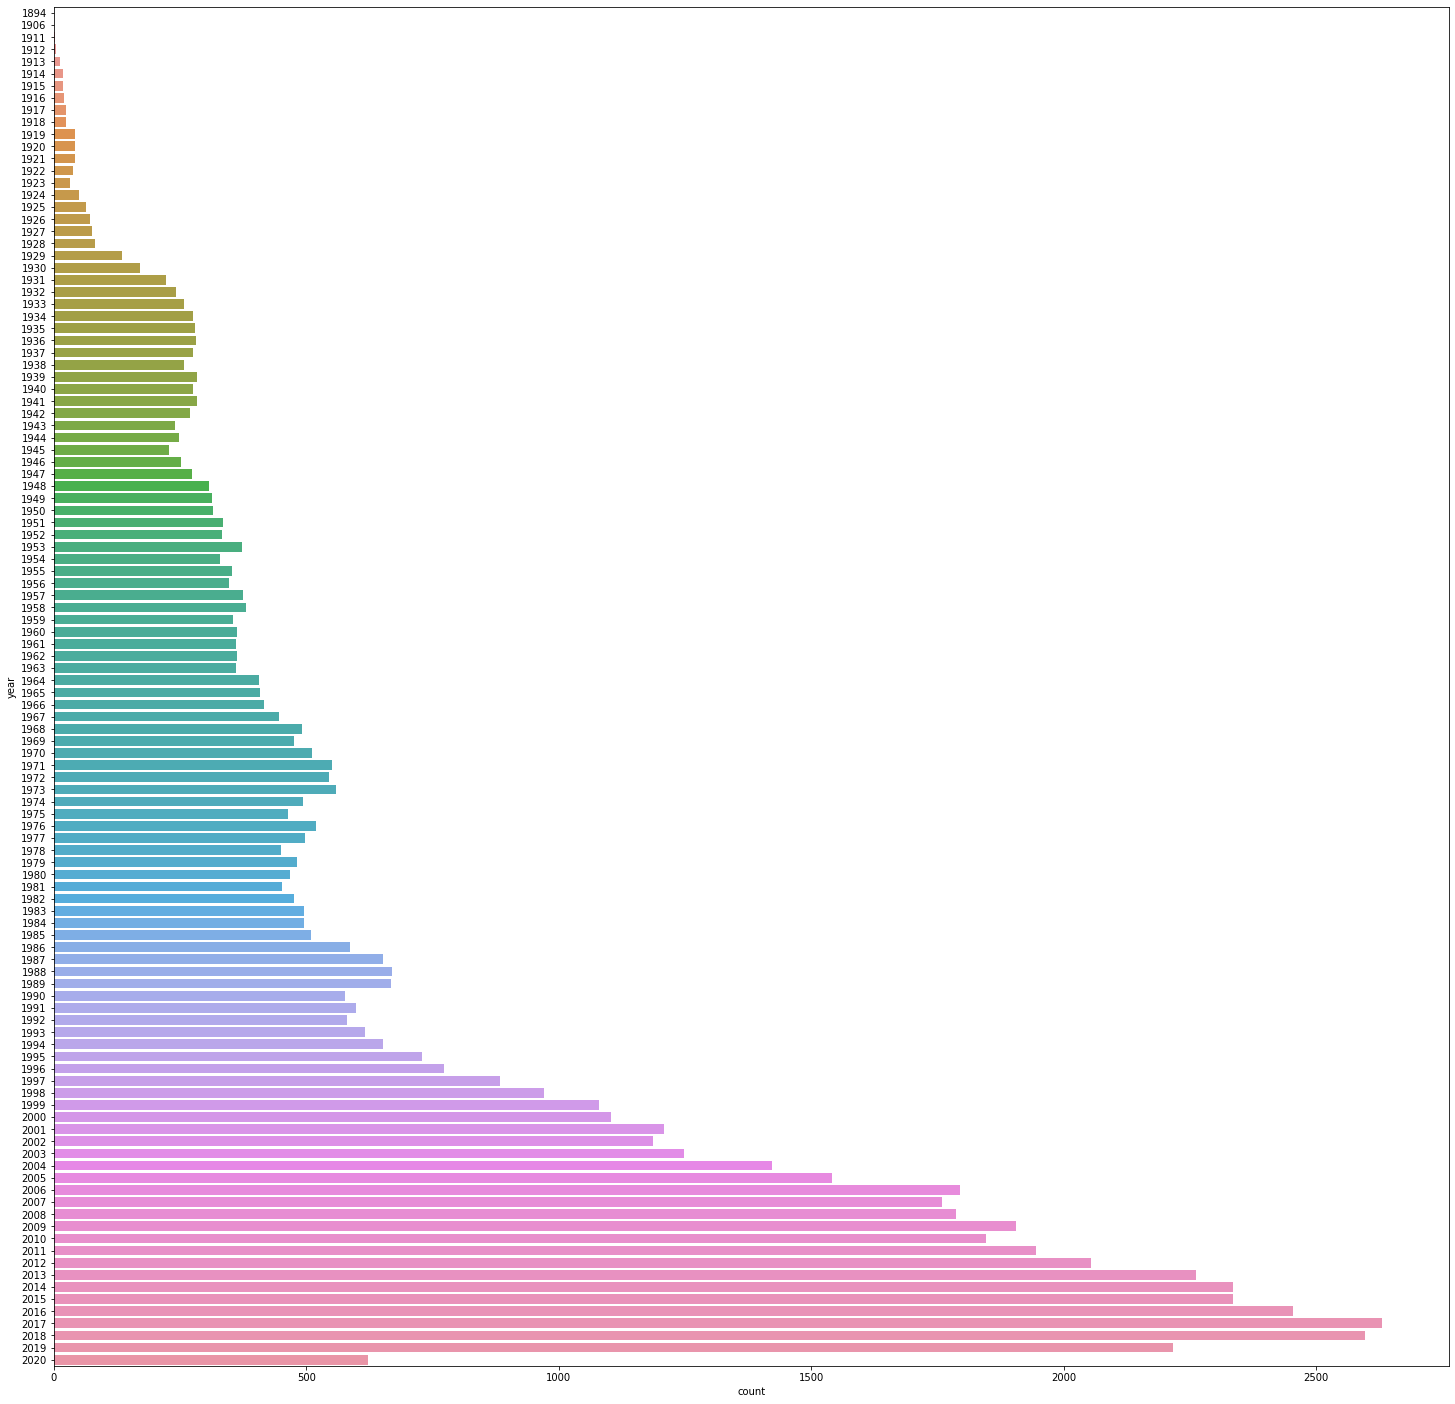

In [12]:
plt.figure(figsize=(25,25))
clean_dataset.sort_values(by=['year'], inplace=True)
sns.countplot(y=clean_dataset['year'], orient='h')

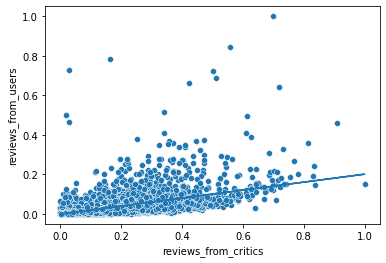

In [13]:
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(clean_dataset[['reviews_from_critics']], clean_dataset['reviews_from_users'])
sns.scatterplot(data=clean_dataset, x='reviews_from_critics', y='reviews_from_users')
plt.plot(clean_dataset['reviews_from_critics'], linear_reg.predict(clean_dataset[['reviews_from_critics']]))

## Word Processing

In [14]:
data1 = clean_dataset[['title', 'genre', 'director', 'actors', 'description']][:30_000]
data1

,title,genre,director,actors,description
0,Miss Jerry,Romance,Alexander Black,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.
1,The Story of the Kelly Gang,"Biography, Crime, Drama",Charles Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...
2,Den sorte drøm,Drama,Urban Gad,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...
4,L'Inferno,"Adventure, Drama, Fantasy","Francesco Bertolini, Adolfo Padovan","Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...
3,Cleopatra,"Drama, History",Charles L. Gaskill,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...
...,...,...,...,...,...
32680,Figli di Annibale,Comedy,Davide Ferrario,"Diego Abatantuono, Silvio Orlando, Valentina C...","A bungling bank robber, an uncooperative hosta..."
32681,Il fiore del silenzio,Horror,James D.R. Hickox,"Malcolm McDowell, Angie Everhart, Richard Grie...",Detective Kelly discovers her partner's disapp...
33973,Rane,"Comedy, Crime, Drama",Srdjan Dragojevic,"Dusan Pekic, Milan Maric, Dragan Bjelogrlic, B...",This film follows two Belgrade youths on their...
33972,The StormRiders - I cavalieri della tempesta,"Action, Adventure, Fantasy",Andrew Lau,"Aaron Kwok, Ekin Cheng, Shin'ichi Chiba, Krist...",An evil warlord takes in 2 students (Wind & Cl...


### Keyword Extraction

In [15]:
data1['keywords'] = ''

for index, row in data1.iterrows():
    r = Rake()
    r.extract_keywords_from_text(row['description'])
    score = r.get_word_degrees()
    row['keywords'] = list(score.keys())
    row['title'] = row['title'].lower()

In [16]:
data1.drop(['description'], axis=1, inplace=True)

In [17]:
data1.set_index('title', inplace=True)

### Bag of Words

In [18]:
data1['bow'] = ''

for index, row in data1.iterrows():
    words = ''
    for col in data1.columns:
        if col == 'keywords':
            words += ' '.join(row[col]) + ' '
        else:
            words += row[col] + ' '
    row['bow'] = words
data1['bow']

title
miss jerry                                      Romance Alexander Black Blanche Bayliss, Willi...
the story of the kelly gang                     Biography, Crime, Drama Charles Tait Elizabeth...
den sorte drøm                                  Drama Urban Gad Asta Nielsen, Valdemar Psiland...
l'inferno                                       Adventure, Drama, Fantasy Francesco Bertolini,...
cleopatra                                       Drama, History Charles L. Gaskill Helen Gardne...
                                                                      ...                        
figli di annibale                               Comedy Davide Ferrario Diego Abatantuono, Silv...
il fiore del silenzio                           Horror James D.R. Hickox Malcolm McDowell, Ang...
rane                                            Comedy, Crime, Drama Srdjan Dragojevic Dusan P...
the stormriders - i cavalieri della tempesta    Action, Adventure, Fantasy Andrew Lau Aaron Kw...
la vendedora d

In [19]:
print(data1['bow'][5])

Biography, Drama Sidney Olcott R. Henderson Bland, Percy Dyer, Gene Gauntier, Alice Hollister, Samuel Morgan, James D. Ainsley, Robert G. Vignola, George Kellog, J.P. McGowan bethlehem visited born jesus christ account birth wise ... shepherds based books foretold life new testament parents  


In [20]:
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectors = vectorizer.fit_transform(data1['bow'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [ ]:
indices = pd.Series(data1.index)
indices[:5]

In [ ]:
cosine_sim = cosine_similarity(df, df)
cosine_sim

In [ ]:
def search(title):
    arr = [t for t in indices if title in t]
    for ind, t in enumerate(arr):
        print(str(ind+1) + '. ' + t)

def top_n_recommended(title='', n=5, cosine_sim=cosine_sim):
    recommended_movies = []
    idx = indices[indices == title].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    #get indexes of the 'n' most similar movies
    top_n_indexes = list(score_series.iloc[1:n+1].index)
    
    #populating the list with titles of n matching movie
    for i in top_n_indexes:
        recommended_movies.append(list(data1.index)[i])
        
    return recommended_movies

In [ ]:
search('a')

In [ ]:
data1.loc[top_n_recommended('a tale of two cities'), :]

In [ ]:
file_name = 'engine.sav'
df.to_pickle(file_name)
df = pd.read_pickle(file_name)

In [ ]:
df